# Lab 4: Building a Spotify Song Classifier with KNNs and Decision Trees
**Classify by genres**. In this lab, you will build machine learning genre classifiers using a dataset of Spotify tracks. Your goal is to train a model that can distinguish between two selected genres based on various audio features such as danceability, energy, valence, tempo, and more.

We'll follow the familiar workflow of data exploration -> preprocessing -> model training -> evaluation

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### Step 1: The data
We'll focus on two genres: Blues and Jazz (what’s the difference, anyway??).

Both genres have rich musical histories, but they differ in structure:

- Blues tends to have simpler chord progressions and a strong emotional expression.
- Jazz often involves complex improvisation and more varied rhythms.

But can a machine really tell them apart just by looking at numerical audio features? That’s what we’ll find out!

In this step, you will:
- Load the dataset
- Extract only blues and jazz for classification

In [2]:
spotify_data = pd.read_csv('/courses/EDS232/Data/spotify_dat.csv')

# Print the data types in spotify_data
print(spotify_data.dtypes)

# Inspect spotify_data
spotify_data.head(3)

id                   object
name                 object
album                object
album_id             object
artists              object
artist_ids           object
track_number          int64
disc_number           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature      float64
year                  int64
release_date         object
genres               object
dtype: object


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date,genres
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0261,0.000011,0.356,0.503,117.906,210133,4.0,1999,1999-11-02,rap metal
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.0129,0.000071,0.155,0.489,103.680,206200,4.0,1999,1999-11-02,rap metal
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.0234,0.000002,0.122,0.370,149.749,298893,4.0,1999,1999-11-02,rap metal


In [3]:
# Filter down to two genres
blues_data = spotify_data[spotify_data['genres'] == 'blues']
jazz_data = spotify_data[spotify_data['genres'] == 'jazz']

# Combine both genres into one dataset
combined_data = pd.concat([blues_data, jazz_data])

# Check the resulting df has the correct genres
print(combined_data['genres'].unique())

# Rename 'genres' column to 'genre' for clarity
combined_data = combined_data.rename(columns = {'genres' : 'genre'})

# Inspect 'combined_data'
combined_data.head(3)

['blues' 'jazz']


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date,genre
333,4MdlxZHzUi8fGvuXOtNVhb,Johnny B. Goode - Live,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],1,1,False,0.415,...,0.023,0.077100,0.9410,0.924,159.366,203407,4.0,1973,1973,blues
334,576DmaRTiVhm3l00mpQwDm,Good Morning Little School Girl - Live,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],2,1,False,0.294,...,0.188,0.422000,0.9740,0.639,187.886,276968,4.0,1973,1973,blues
335,3k3Q8IZ5oOqCUfOP2UPgpW,I'll Drown in My Tears,Johnny Winter: A Rock N' Roll Collection,6yn5Mylr8HsH9PVro7Fo22,['Johnny Winter'],['2ODUxmFxJSyvGiimNhMHbO'],3,1,False,0.424,...,0.827,0.000021,0.0742,0.390,95.799,285360,3.0,1973,1973,blues


## Step 2: Data Exploration
Now that we have Blues and Jazz as our two genres, it's time to explore the data and look for patterns in the audio features.

Let's investigate:
- Which features are available?
- How strongly these features correlate with each other.
- How different genres distribute across  sample features: danceability 

In this step, we will:
- Filter out non-numeric columns before the plotting
- Visualize feature correlations using a heatmap.
- Examine key feature distributions with histograms to see if genres behave differently.


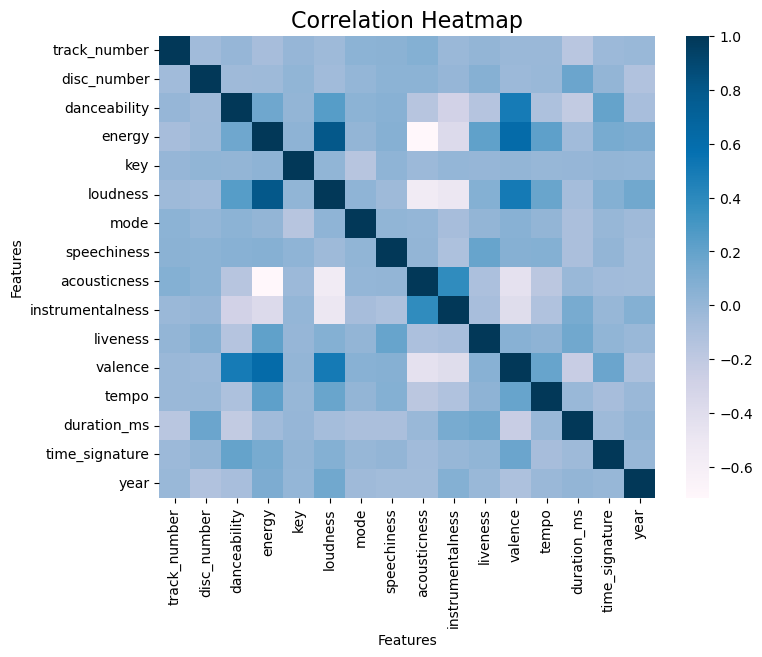

In [4]:
# Exclude non-numeric columns but keep 'genre' for grouping
numeric_features = combined_data.select_dtypes(include = 'number')
#numeric_features['genre'] = combined_data['genre']

# Define values for jazz and blues
#genre_values = {'blues' : 1, 'jazz' : 0}

# Assign values to genre column
#numeric_features['genre'] = combined_data['genre'].map(genre_values)


# Correlation heatmap
# Initialize figure
plt.figure(figsize = (8, 6))

# Choose jazzy-bluesy color scale
sns.heatmap(numeric_features.corr(), cmap = 'PuBu') 
plt.title('Correlation Heatmap', fontsize = 16)
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()


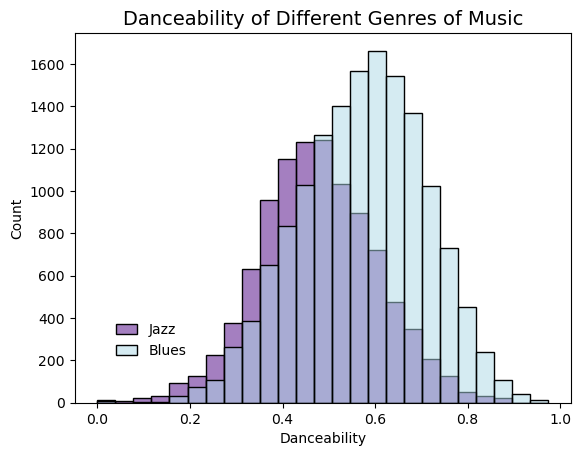

In [5]:
# Set custom colors for the genres
color_map = {'blues': 'lightblue', 'jazz': 'indigo'}

# Plot the histogram 
sns.histplot(combined_data, 
             x = 'danceability', 
             bins = 25,
             hue = 'genre', 
             palette = color_map)

# Add title and labels
plt.title('Danceability of Different Genres of Music', fontsize = 14, ha = 'center')
plt.xlabel('Danceability')

# Customize the legend
plt.legend(labels = ['Jazz', 'Blues'],
           bbox_to_anchor = (0.25, .25), 
           markerscale = 5, 
           frameon = False, 
           markerfirst = True, 
           labelspacing = 0.5, 
           handlelength = 1.5)

plt.show()

### Step 3: Check for class imbalance
An unequal distribution between the target classes can cause issues for our classifiers, so we'll need to check for that. A commonly used guideline for class imbalance is:

- Slight Imbalance (Less than 1.5:1) → Generally okay; no need for balancing.
- Moderate Imbalance (Between 1.5:1 and 3:1) → Might cause some bias; balancing can help.
- Severe Imbalance (More than 3:1) → Strongly affects model performance; balancing is usually necessary.

In [6]:
# Print counts of each genre
class_counts = combined_data['genre'].value_counts()

# Calculate ratio of majority to minority class
class_ratio = class_counts["blues"] / class_counts["jazz"]

# Print class distribution and ratio
print(f" class distribution:\n {class_counts}")
print(f"class ratio: {class_ratio:.2f}")

 class distribution:
 genre
blues    14811
jazz     10023
Name: count, dtype: int64
class ratio: 1.48


Given this result, should we be worried about the imbalance?

Given opur results are a ratio of 1.48:1, a smaller ratio than the convention for 'slight imbalance', I am ot worried about the class imbalance of thi

### Step 4: Preprocessing
We need to ensure all the variables we use are numerical so the models can process them. First we'll drop all the variables that are not numeric or the target. Then we'll use a sklearn utility, `LabelEncoder()` to encode our categorical target variable into numerical values. Print the first five values of your encoded labels.

In [7]:
# Add 'genre' back to 'numeric_features'
numeric_features['genre'] = combined_data['genre']

# Define the features (drop columns that are not numeric or target)
X = numeric_features.drop("genre", axis = 1)

# Set the target variable as 'genre'
y = numeric_features["genre"]

# Encode the target variable ('label') using label encoding
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

# Print first five values of encoded labels
y_encoded[:5]

array([0, 0, 0, 0, 0])

Good, now we'll do our data splitting and scaling.  Let's go with an 80/20 split this time.

In [8]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the training set
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test set
X_test_scaled = scaler.transform(X_test)

### Step 5: Train the models
OK, now it's time to build our models and assess the training accuracy. We'll use the default of k = 5 for the KNN model.

In [9]:
# Initialize models
knn = KNeighborsClassifier(n_neighbors = 5)
dt =  DecisionTreeClassifier()

# Train (fit) both models
knn.fit(X_train_scaled, y_train)
dt.fit(X_train_scaled, y_train)

# Predictions on training data
knn_y_train_pred = knn.predict(X_train_scaled)
dt_y_train_pred = dt.predict(X_train_scaled)

# Compute training accuracy
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)

#Print training accuracy for both models
print(f"KNN Model Train Accuracy: {knn_train_accuracy * 100:.2f}%\n",
    f"Decision Tree Model Train Accuracy: {dt_train_accuracy * 100:.0f}%")

KNN Model Train Accuracy: 92.10%
 Decision Tree Model Train Accuracy: 100%


### Step 6: Evaluate models
OK, now let's go ahead and predict on the test data to see how well our models do at predicting the genre of unseen tracks.

In [10]:
# Make predictions
knn_pred = knn.predict(X_test_scaled)
dt_pred = dt.predict(X_test_scaled)

# Evaluate prediction accuracy
knn_accuracy = accuracy_score(y_test, knn_pred)
dt_accuracy = accuracy_score(y_test, dt_pred)

#Print prediction accuracy for both models
print(f"KNN Model Test Acurracy: {knn_accuracy * 100:.2f}%\n",
    f"Decision Tree Model Test Acurracy: {dt_accuracy * 100:.2f}%")

KNN Model Test Acurracy: 89.17%
 Decision Tree Model Test Acurracy: 85.38%


### Step 7: Visualizing Model Performance
Now that we have evaluated our models on unseen data, let’s compare their performance by visualizing the training vs. test accuracy.  We'll look for signs of overfitting by plotting the training accuracy and test accuracy for both k-NN and Decision Trees.

Create a bar chart that compares the training accuracy and test accuracy for k-NN and Decision Trees. Your plot should clearly display:

- The training and test accuracy for both models.
- Properly labeled axes and a title.
- A legend to differentiate training and test accuracy.
- Accuracy values displayed on top of each bar.

<Figure size 1000x600 with 0 Axes>

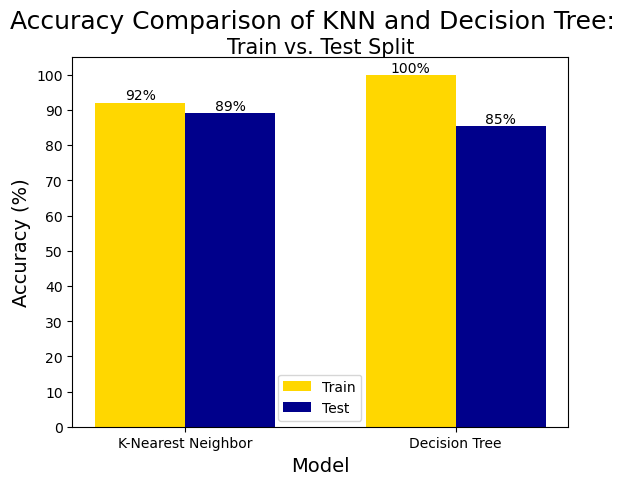

In [11]:
# Prepare component data and labels
train_results = [knn_train_accuracy * 100, dt_train_accuracy * 100] # Convert results to a percentage
test_results = [knn_accuracy * 100, dt_accuracy * 100]
model = ['K-Nearest Neighbor', 'Decision Tree']

# Make a barchart to visualize the training vs. test accuracy for knn and decision trees models
# Initialize the figure
plt.figure(figsize = (10,6))

fig, ax = plt.subplots()

# Plot the training accuracy
train_bars = ax.bar([0, 0.75],  # location of bars on x axis
       train_results, 
       width = 0.25, 
       label = 'Training Accuracy', 
       color = 'gold')
   
# Plot the test accuracy
test_bars = ax.bar([0.25, 1], # location of bars on x axis
       test_results, 
       width = 0.25, 
       label = 'Test Accuracy', 
       color = 'darkblue')

# Add test accuracy values to the top of the bars
ax.text(test_bars[0].get_x() + test_bars[0].get_width() / 2, # X value for label using location and width of bar
        test_bars[0].get_height(), # Y value for label using height of bar
        f'{test_bars[0].get_height():.0f}%', 
        ha = 'center', 
        va = 'bottom', 
        fontsize = 10)

ax.text(test_bars[1].get_x() + test_bars[1].get_width() / 2, test_bars[1].get_height(), 
        f'{test_bars[1].get_height():.0f}%', 
        ha = 'center', 
        va = 'bottom', 
        fontsize = 10)

# Add training accuracy values to the top of the bars
ax.text(train_bars[0].get_x() + train_bars[0].get_width() / 2, train_bars[0].get_height(), 
        f'{train_bars[0].get_height():.0f}%', 
        ha = 'center', 
        va = 'bottom', 
        fontsize = 10)

ax.text(train_bars[1].get_x() + train_bars[1].get_width() / 2, train_bars[1].get_height(), 
        f'{train_bars[1].get_height():.0f}%', 
        ha = 'center', 
        va = 'bottom', 
        fontsize = 10)
 
# Adjust tick marks
ax.set_xticks([0.125, 0.875])
ax.set_xticklabels(model)
ax.set_yticks(range(0, 110, 10))


# Add labels
plt.xlabel('Model', fontsize = 14)
plt.ylabel('Accuracy (%)', fontsize = 14)
plt.suptitle('Accuracy Comparison of KNN and Decision Tree:', fontsize = 18, ha = 'center')
plt.title('Train vs. Test Split', fontsize = 15, ha = 'center', va = 'top')

# Adjust legend
plt.legend(labels = ['Train', 'Test'],
           bbox_to_anchor = (0.4, 0.16)) # Locate legend

plt.show()

Which model does a better job of generalizing to unseen data? How do you know?
Does it appear that either of the models are overfitting? Why?

The KNN model does a better job of generalizing to unseen data because the test accuracy is higher than the decision tree model test. There is also a smaller spread in accuracy between train and test for the KNN model (3%) compared to the decision tree model (15%). The decision tree train model has an accuracy of 100%, which suggests that it is overfit. Realistically, a model should have some error. This overfitting would also explain the larger drop in accuracy when generalizing unseen data.

### Bonus question
In the workflow above, we used the default parameter values of k = 5 for the KNN model, and maxdepth = None for the Decision Tree. Choose one of the models and see if you can improve test performance by optmizing its corresponding parameter value.

## Improve the Decison Tree model:
### Re-scale data

In [12]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the training set
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test set
X_test_scaled = scaler.transform(X_test)

### Find the accuracy at different Decision Tree depths

In [13]:
# Create a list to store the accuracies
accuracies = []

# Function to fit a model/obtain accuaracy
def decision_tree(depth):
    
    # Initialize with current depth
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train_scaled, y_train) # Fit the model on the training data
    
    # Make predictions on the test set
    y_pred = dt.predict(X_test_scaled) 
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) 
    accuracies.append(accuracy)  # Add accuracy to accuracies list

# Loop through max depths
max_depths = range(1, 100)
for depth in max_depths:
    decision_tree(depth)

# Store values in a dataframe   
depth_test = pd.DataFrame({'n_depth': list(max_depths),
              'accuracy_val': accuracies})

### Calculate the ideal depth

In [14]:
# Extract the ten highest accuracy values
ideal_depth_accuracy = depth_test.nlargest(10, 'accuracy_val')

# Find teh average depth from the highest accuracies
ideal_depth = round(ideal_depth_accuracy['n_depth'].sum() / 10)

print(f"Ideal depth: {ideal_depth}")

Ideal depth: 10


### Train the model with ideal depth

In [15]:
# Initialize model
dt_ideal =  DecisionTreeClassifier(max_depth = ideal_depth)

# Fit model
dt_ideal.fit(X_train_scaled, y_train)

# Predictions on training data
dt_ideal_y_train_pred = dt_ideal.predict(X_train_scaled)

# Calculate training accuracy
dt_ideal_train_accuracy = accuracy_score(y_train, dt_ideal_y_train_pred)

#Print training accuracy for both models
print(f"Ideal Decision Tree Train Accuracy: {dt_ideal_train_accuracy* 100:.2f}%")

Ideal Decision Tree Train Accuracy: 93.72%


### Test the model with ideal depth

In [16]:
# Make predictions
dt_ideal_pred = dt_ideal.predict(X_test_scaled)

# Evaluate prediction accuracy
dt_ideal_accuracy = accuracy_score(y_test, dt_ideal_pred)

#Print prediction accuracy for both models
print(f"Ideal Decision Tree Test Accuracy: {dt_ideal_accuracy* 100:.2f}%\n")

Ideal Decision Tree Test Accuracy: 87.75%



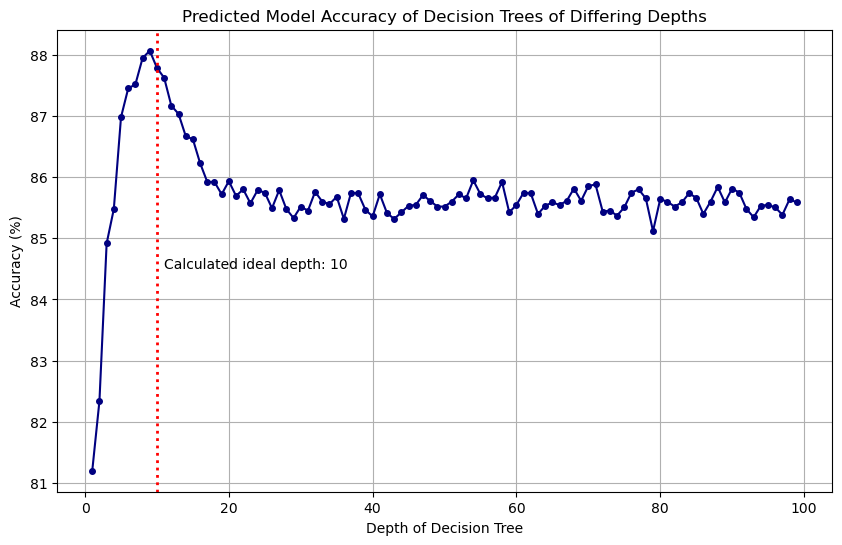

In [17]:
# Visualize the effect of depth on accuracy
plt.figure(figsize=(10,6))

plt.plot(depth_test['n_depth'],
         depth_test['accuracy_val'] * 100,
         color = 'navy', 
         linestyle='solid', 
         marker = 'o',
         markersize = 4)

# Add a vertical red dotted line at x = 10
plt.axvline(x = ideal_depth, color = 'red', linestyle=':', linewidth=2)

plt.annotate(f'Calculated ideal depth: {ideal_depth}', 
             xy = (10, 84), 
            xytext=(11, 84.5),
             fontsize = 10)

# Add labels
plt.title('Predicted Model Accuracy of Decision Trees of Differing Depths')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

### Conclusion

I was able to improve the performance of our model by 2+% by optimizing the K value to 10. By finding the accuracy of every model with K values ranging from 1 - 99, we were able to calculate the average of the parameter value for the best performing models. I then rounded this average and applied it to our model. The model was then trained and tested, yielding a test accuracy of 87.8%, an improvement from the original accuracy value of 85.7%. When we plot the results, we can see that our calculated K value aligns closely with the values predicted to yield higher accuracy.
